In [91]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, mapping
from libpysal.weights import KNN
from spreg import ML_Lag
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from esda import Moran

In [92]:
property = gpd.read_file('data/cycle/Market_value_usable_hedonic_data.csv', engine='pyogrio')
canopy = gpd.read_file('data/canopy.gdb', engine='pyogrio')
ta = gpd.read_file('data/chc-boundaries/territorial-authority-2021-generalised.gpkg', engine='pyogrio')
sa2 = gpd.read_file('data/chc-boundaries/sa2/statistical-area-2-2023-generalised.shp')

In [93]:
ta_chc = ta[ta['TA2021_V1_00_NAME_ASCII'] == 'Christchurch City']
sa2_chc = gpd.clip(sa2, ta_chc)
boundary = sa2_chc.copy(deep=True)

In [94]:
# comment this cell to display folium plot
# boundary = sa2_chc[sa2_chc['SA22023__2'].str.lower().str.contains('fendalton')]
canopy = gpd.clip(canopy, boundary)

In [ ]:
property_2018 = property[(property['YearSold'].isin(['2017', '2018', '2019'])) & (property['LandArea'] != '0.0')]

# add year dummies
year_dummies = pd.get_dummies(property_2018['YearSold'], prefix='year', drop_first=True)
property_2018_with_dummies = pd.concat([property_2018, year_dummies], axis=1)

In [ ]:
property_gdf = gpd.GeoDataFrame(
  property_2018_with_dummies,
  geometry = gpd.points_from_xy(property_2018_with_dummies['gd2000co'], property_2018_with_dummies['gd2000_yco']),
  crs=4326
).to_crs(2193)

gdf_chc = gpd.clip(property_gdf, boundary)
canopy_chc = canopy.copy(deep=True)

In [116]:
# gdf_chc = gdf_chc.loc[:, ['GrossSalePrice','AgeAtSale', 'LandArea', 'TotalFloorArea', 'water_DIST', 'bus_DIST', 'Census_Pop', 'RnkIMDNoEm',
#        'RnkIMDNoIn', 'RnkIMDNoCr', 'RnkIMDNoHo', 'RnkIMDNoHe', 'RnkIMDNoEd',
#        'RnkIMDNoAc', 'CBD_DIST', 'geometry']]

gdf_chc = gdf_chc.loc[:, ['GrossSalePrice','AgeAtSale', 'LandArea', 'TotalFloorArea', 'water_DIST', 'bus_DIST', 'Census_Pop', 'RnkIMDNoEm',
       'RnkIMDNoIn', 'RnkIMDNoCr', 'RnkIMDNoHo', 'RnkIMDNoHe', 'RnkIMDNoEd',
       'RnkIMDNoAc', 'DECILE_high', 'DECILE_prim', 'Median_Income', 'CBD_DIST', 'geometry',
       'cycleways_DIST', 'cycle_DENS', 
       'year_2018', 'year_2019'
       # 'on_DIST', 'on_DENS'
       ]]

In [117]:
gdf_chc["buf_20"]  = gdf_chc.geometry.buffer(20)
gdf_chc["buf_50"]  = gdf_chc.geometry.buffer(50)
gdf_chc["buf_100"] = gdf_chc.geometry.buffer(100)
gdf_chc["buf_200"] = gdf_chc.geometry.buffer(200)

def make_buffer_gdf(buf_series):
    return (gpd.GeoDataFrame({"geometry": buf_series}, crs=2193)
              .reset_index()
              .rename(columns={"index": "prop_id"}))

buf20  = make_buffer_gdf(gdf_chc["buf_20"])
buf50  = make_buffer_gdf(gdf_chc["buf_50"])
buf100 = make_buffer_gdf(gdf_chc["buf_100"])
buf200 = make_buffer_gdf(gdf_chc["buf_200"])

def canopy_area_overlay(canopy, buffers):
    inter = gpd.overlay(
        buffers,
        canopy,
        how="intersection",
        keep_geom_type=False
    )
    inter["area"] = inter.geometry.area
    return inter.groupby("prop_id")["area"].sum()

def canopy_area_sjoin(canopy, buffers):
    joined = gpd.sjoin(
        canopy,
        buffers,
        how="inner",
        predicate="intersects"
    )
    joined["area"] = joined.geometry.area
    return joined.groupby("prop_id")["area"].sum()

area_0_20  = canopy_area_overlay(canopy_chc, buf20)
area_0_50  = canopy_area_overlay(canopy_chc, buf50)
area_0_100 = canopy_area_sjoin(canopy_chc, buf100)
area_0_200 = canopy_area_sjoin(canopy_chc, buf200)

gdf_chc["canopy_0_20"]   = gdf_chc.index.map(area_0_20).fillna(0)
gdf_chc["canopy_0_50"]   = gdf_chc.index.map(area_0_50).fillna(0)
gdf_chc["canopy_0_100"]  = gdf_chc.index.map(area_0_100).fillna(0)
gdf_chc["canopy_0_200"]  = gdf_chc.index.map(area_0_200).fillna(0)

gdf_chc["canopy_20_50"]  = gdf_chc["canopy_0_50"] - gdf_chc["canopy_0_20"]
gdf_chc["canopy_50_100"]  = gdf_chc["canopy_0_100"] - gdf_chc["canopy_0_50"]
gdf_chc["canopy_100_200"] = gdf_chc["canopy_0_200"] - gdf_chc["canopy_0_100"]

In [99]:
# # uncomment this cell to print folium interactive map

# canopy_4326 = canopy_chc.to_crs(epsg='4326')
# gdf_4326 = gdf_chc.to_crs(epsg='4326').sample(n=2)

# gdf_4326["buf_20"] = gdf_chc["buf_20"].to_crs(4326)
# gdf_4326["buf_50"] = gdf_chc["buf_50"].to_crs(4326)
# gdf_4326["buf_100"] = gdf_chc["buf_100"].to_crs(4326)
# gdf_4326["buf_200"] = gdf_4326["buf_200"].to_crs(4326)

# # obtain center of map
# minx, miny, maxx, maxy = canopy_4326.total_bounds
# lon = (minx + maxx) / 2
# lat = (miny + maxy) / 2

# m = folium.Map(location=(lat, lon), zoom_start=17, tiles=None)

# folium.TileLayer(
#   'cartodbpositron',
#   name='CartoDB Positron'
# ).add_to(m)

# buffers = [
#   {"key": "buf_20", "color": "red", "opacity": 0.6},
#   {"key": "buf_50", "color": "purple", "opacity": 0.4},
#   {"key": "buf_100", "color": "yellow", "opacity": 0.3},
#   {"key": "buf_200", "color": "blue", "opacity": 0.2}
# ]

# for buffer in buffers:
#   for geom in gdf_4326[buffer['key']]:
#     folium.GeoJson(mapping(geom),
#                   style_function=lambda x, c=buffer['color'], o=buffer['opacity']: {
#                     'color': c,
#                     'weight': 1,
#                     'fillOpacity': o
#                   }).add_to(m)
  
# for geom in canopy_4326['geometry']:
#   folium.GeoJson(
#     mapping(geom),
#     style_function=lambda x: {
#       'color': 'green',
#       'weight': 1,
#       'fillOpacity': 0.3
#     }
#   ).add_to(m)

# for geom in gdf_4326.geometry:
#   folium.CircleMarker(
#     location=[geom.y, geom.x],
#     radius=3,
#     color='red'
#   ).add_to(m)

# m

In [118]:
gdf_chc.drop(inplace=True, columns=[
  'buffer_100m',
  'buf_20',
  'buf_50',
  'buf_100',
  'buf_200',
  'canopy_0_50',
  'canopy_0_100',
  'canopy_0_200',
  # 'canopy_0_20',
  # 'canopy_20_50',
  # 'canopy_50_100',
  # 'canopy_100_200',
], errors='ignore')

In [119]:
for col in gdf_chc.columns:
  if col != 'geometry':
    gdf_chc[col] = pd.to_numeric(gdf_chc[col], errors='coerce')
    
gdf_chc['year_2018'] = gdf_chc['year_2018'].astype(int)
gdf_chc['year_2019'] = gdf_chc['year_2019'].astype(int)

In [120]:
gdf_chc_scaled = gdf_chc.copy(deep=True)
gdf_chc_scaled['log_price'] = np.log(gdf_chc['GrossSalePrice'])

dummy_cols = ['year_2018', 'year_2019']

numeric_cols = [
    col for col in gdf_chc_scaled.columns 
    if col not in ["geometry", "GrossSalePrice", "log_price"] + dummy_cols
]

for col in numeric_cols:
    gdf_chc_scaled[col] = (gdf_chc_scaled[col] - gdf_chc_scaled[col].mean()) / gdf_chc_scaled[col].std()

In [123]:
X = gdf_chc_scaled[numeric_cols + dummy_cols]

X = sm.add_constant(X)

y = gdf_chc_scaled["log_price"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1170.
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:17:15   Log-Likelihood:                 3389.1
No. Observations:               12431   AIC:                            -6726.
Df Residuals:                   12405   BIC:                            -6533.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.1428      0.003   4391.714      0.000      13.137      13.149
AgeAtSale         -0.0425      0.002    -21.420      0.000      -0.046      -0.039
LandArea           0.0307      0.002     17.549      0.000       0.027       0.034
TotalFloorArea     0.1770      0.002     86.889      0.000       0.173       0.181
water_DIST         0.0213      0.002     10.625      0.000       0.017       0.025
bus_DIST           0.0163      0.002      8.662      0.000       0.013       0.020
Census_Pop        -0.0038      0.002     -2.190      0.029      -0.007      -0.000
RnkIMDNoEm        -0.1535      0.013    -12.003      0.000      -0.179      -0.128
RnkIMDNoIn        -0.0436      0.014     -3.207      0.001      -0.070      -0.017
RnkIMDNoCr        -0.2236      0.021    -10.790      0.000      -0.264      -0.183
RnkIMDNoHo        -0.2900      0.021    -13.933      0.000      -0.331      -0.249
RnkIMDNoHe        -0.2106      0.013    -15.741      0.000      -0.237      -0.184
RnkIMDNoEd        -0.1147      0.021     -5.377      0.000      -0.156      -0.073
RnkIMDNoAc         0.9623      0.069     13.949      0.000       0.827       1.097
DECILE_high        0.0377      0.002     18.036      0.000       0.034       0.042
DECILE_prim        0.0093      0.002      4.753      0.000       0.005       0.013
Median_Income      0.0493      0.002     20.959      0.000       0.045       0.054
CBD_DIST          -0.0453      0.003    -17.746      0.000      -0.050      -0.040
cycleways_DIST    -0.0177      0.002     -7.979      0.000      -0.022      -0.013
cycle_DENS         0.0110      0.002      4.872      0.000       0.007       0.015
canopy_0_20        0.0088      0.002      4.096      0.000       0.005       0.013
canopy_20_50       0.0122      0.002      5.120      0.000       0.008       0.017
canopy_50_100      0.0024      0.002      1.205      0.228      -0.001       0.006
canopy_100_200     0.0052      0.002      2.635      0.008       0.001       0.009
year_2018          0.0011      0.004      0.274      0.784      -0.007       0.009
year_2019          0.0214      0.004      5.203      0.000       0.013       0.030
==============================================================================
Omnibus:                     2855.393   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153003.409
Skew:                           0.076   Prob(JB):                         0.00
Kurtosis:                      20.186   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
print(gdf_chc['canopy_0_20'].std())
print(gdf_chc['canopy_20_50'].std())
print(gdf_chc['GrossSalePrice'].mean())

108.50716096423331
481.32706251412293
546944.7268120022


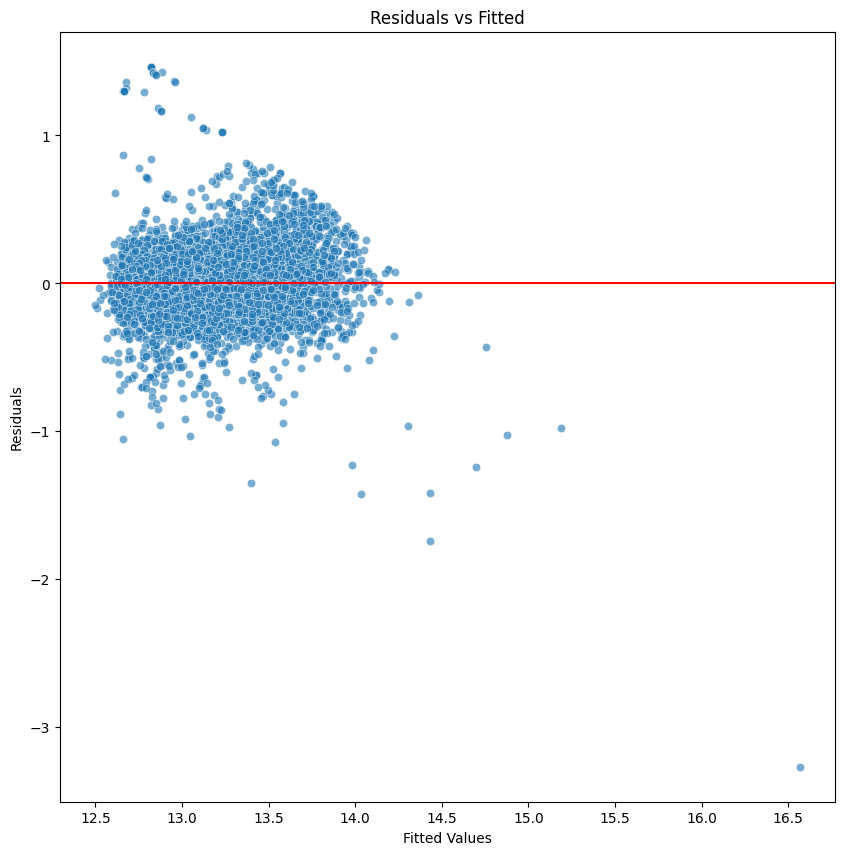

In [125]:
fitted = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(10, 10))
sns.scatterplot(x=fitted, y = residuals, alpha = 0.6)
plt.axhline(0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

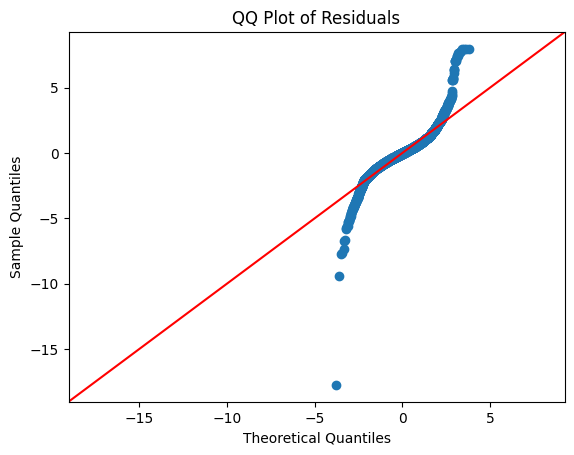

In [126]:
import statsmodels.api as sm
sm.qqplot(model.resid, line="45", fit=True)
plt.title("QQ Plot of Residuals")
plt.show()


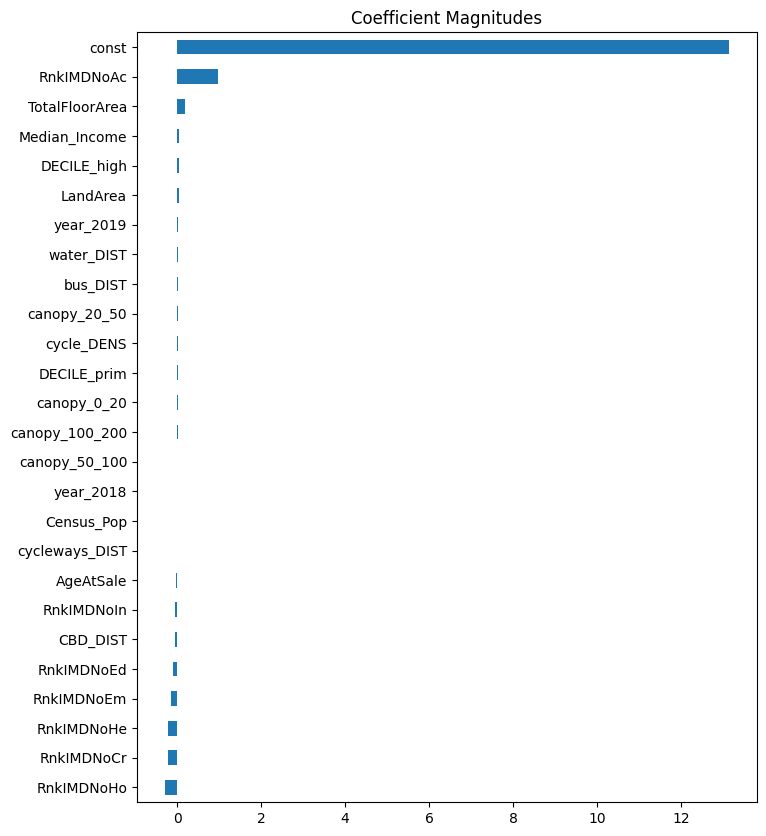

In [127]:
coef = model.params.sort_values()
coef.plot(kind='barh', figsize=(8,10))
plt.title("Coefficient Magnitudes")
plt.show()


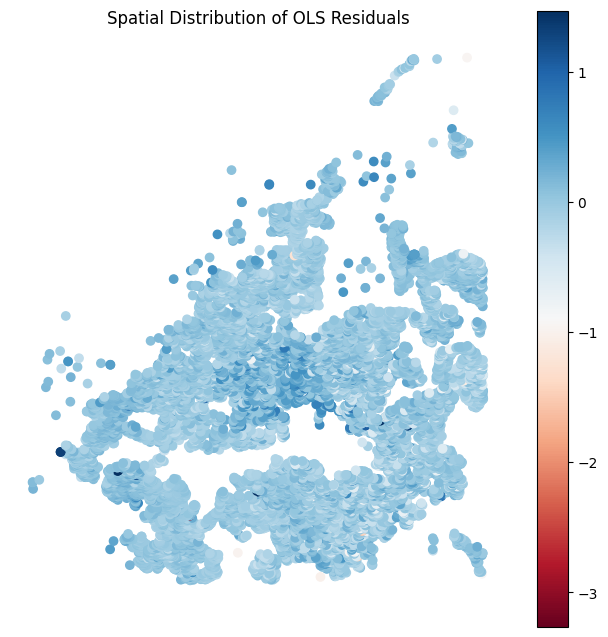

In [128]:
gdf_chc["residuals"] = model.resid
gdf_chc.plot(column="residuals", cmap="RdBu", legend=True, figsize=(8,8))
plt.title("Spatial Distribution of OLS Residuals")
plt.axis("off")
plt.show()


In [129]:
w = KNN.from_dataframe(gdf_chc_scaled, k=8)
w.transform = 'R'

/Users/rujalshrestha/Projects/chc-property-prices/venv/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [130]:
mi = Moran(gdf_chc_scaled['GrossSalePrice'], w)

print("Moran's I: ", mi.I)
print("Expected I: ", mi.EI)
print("p-value: ", mi.p_sim)

Moran's I:  0.6138859706628869
Expected I:  -8.045052292839903e-05
p-value:  0.001


# Moran's I for residuals

In [131]:
gdf_chc.head()

,GrossSalePrice,AgeAtSale,LandArea,TotalFloorArea,water_DIST,bus_DIST,Census_Pop,RnkIMDNoEm,RnkIMDNoIn,RnkIMDNoCr,...,geometry,cycleways_DIST,cycle_DENS,year_2018,year_2019,canopy_0_20,canopy_20_50,canopy_50_100,canopy_100_200,residuals
1560,610000,24,685.0,211.0,189.601703,216.798910,930.0,1811.0,849.0,1231.0,...,POINT (1564919.129 5174157.305),590.000000,1.6,0,1,1.077267,163.500474,3673.623939,10193.360430,0.024190
3842,477500,42,609.0,120.0,139.581200,154.824709,930.0,1811.0,849.0,1231.0,...,POINT (1565047.92 5174178.753),471.071045,1.6,0,0,20.957896,450.415001,3568.941048,19805.408025,0.078981
3671,655000,22,704.0,245.0,201.942495,192.941029,930.0,1811.0,849.0,1231.0,...,POINT (1564904.931 5174179.536),610.836121,1.6,1,0,10.299413,144.270775,2970.792200,9872.392485,0.015931
3239,500000,44,869.0,131.0,157.854014,179.645498,930.0,1811.0,849.0,1231.0,...,POINT (1565029.188 5174201.753),483.016235,1.6,0,1,74.306779,392.823676,3602.928325,19098.845813,0.065992
3781,880000,22,1149.0,279.0,199.693219,216.730600,930.0,1811.0,849.0,1231.0,...,POINT (1564988.184 5174211.698),533.936462,1.6,1,0,0.000000,279.813206,6163.843751,14113.518330,0.196085


In [132]:
gdf_chc_scaled['residuals'] = model.resid

mi_res = Moran(gdf_chc_scaled['residuals'], w)

print("Residual Moran's I:", mi_res.I)
print("Expected I:", mi_res.EI)
print("p-value:", mi_res.p_sim)

Residual Moran's I: 0.29679356044953287
Expected I: -8.045052292839903e-05
p-value: 0.001


In [133]:
gdf_chc['residuals'] = model.resid

In [134]:
gdf_chc.to_file('output/hedonic_gdf.gpkg')